# Final Notebook 2: Food Access in LA County
## Group Members: Madi Hamilton, Jessica Fay, Meaghan Woody, Branden Bohrnsen
### UP221 Winter 2024

### Description
**Research Question:** Are there geographic disparities trends in food insecurity in Los Angeles County?

**Notebook purpose:** (1) Analyze data using Walksheds maps, (2) Analuze data using Folium layered maps

**Data sources:**
1. USC Neighborhood Data for Social Change
2. U.S. Census Bureau - American Community Survey 2016-2020
3. U.S. Census Tracts 2020
4. Grocery Store Walkability

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import contextily as ctx
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import folium
import plotly.express as px
from sodapy import Socrata
import mapclassify
from shapely.geometry import Point
import seaborn as sns

### Prepare Mapping Data

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


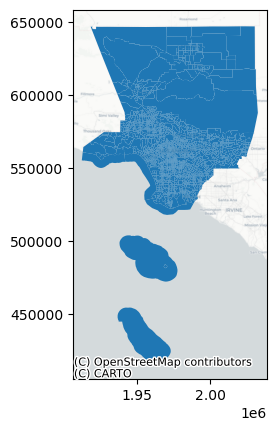

In [2]:
tracts = gpd.read_file('tl_2020_06_tract.shp')
tracts = tracts.to_crs('epsg:6423')
latracts = tracts.query("COUNTYFP == '037'")
ax =latracts.plot()
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')
columns_to_keep = ['GEOID','geometry']
latracts1 = latracts[columns_to_keep]
latracts1['FIPS'] = latracts.GEOID

### Prepare Grocery Store Walkability

In [3]:
# Import data
food=pd.read_csv('finaldata_0303.csv', dtype={'FIPS_census':str})

# Data cleaning
a= food['lowaccess_count']
b=food['denom_total_pop']
food['lowaccess_pct']=round((a/b)*100)
new = food[food['% Hispanic or Latino'] <= 100]
new['FIPS'] = new.FIPS_census

new['FIPS'] = new.FIPS.str[-8:]
new['FIPS'] = new.FIPS.str[:6]
new.FIPS.head(5)

latracts1['FIPS']=latracts1.FIPS.str[-6:]
latracts1.FIPS.head(5)

/tmp/ipykernel_1587/3814988142.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['FIPS'] = new.FIPS_census
/tmp/ipykernel_1587/3814988142.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['FIPS'] = new.FIPS.str[-8:]
/tmp/ipykernel_1587/3814988142.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

17     262601
62     300100
65     300501
78     310701
211    300200
Name: FIPS, dtype: object

In [4]:
# Merge data
tracts_census= pd.merge(new,latracts1,on='FIPS')

tracts_census = gpd.GeoDataFrame(tracts_census, geometry='geometry', crs='epsg:6423')

In [5]:
# Creating Food Insecurity Index
#telling mapclassify to create categorical variables with 5 options
classifier = mapclassify.NaturalBreaks.make(k=5)

tracts_census['age_pct_score'] = tracts_census[['Percent 65 years and over']].apply(classifier)
tracts_census['hisp_pct_score'] = tracts_census[['% Hispanic or Latino']].apply(classifier)
tracts_census['emp_pct_score'] = tracts_census[['% Unemployed']].apply(classifier)
tracts_census['priority_index'] = tracts_census['age_pct_score']+tracts_census['hisp_pct_score']+tracts_census['emp_pct_score']
tracts_census['priority_index'].head()

0    6
1    6
2    9
3    9
4    7
Name: priority_index, dtype: int64

## Creating Subset of Census Tracts

In [6]:
merged_index = tracts_census.sort_values(by='priority_index', ascending=False)

array([[<Axes: title={'center': 'priority_index'}>]], dtype=object)

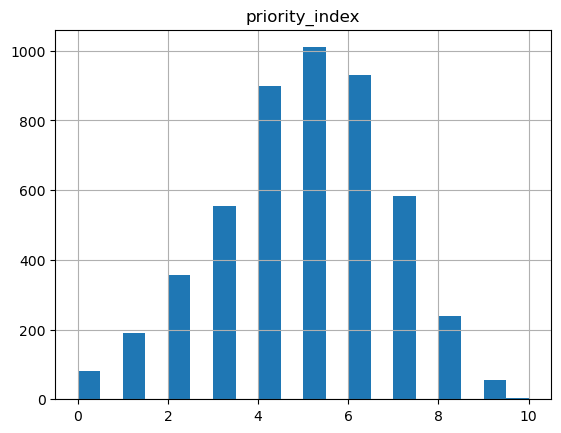

In [7]:
merged_index.hist('priority_index',bins=20)

In [8]:
merged_index = merged_index.head(5)

In [9]:
merged_index = merged_index.to_crs('EPSG:6423')

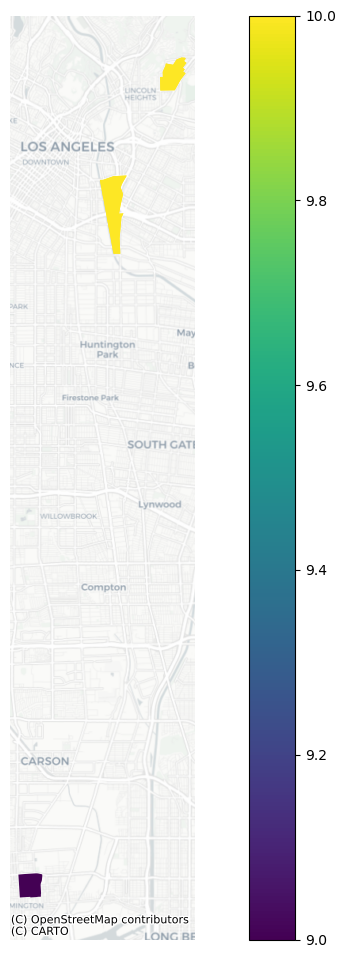

In [10]:
ax = merged_index.plot(column='priority_index',legend=True,figsize=(14,12), missing_kwds={'color':'lightgrey'})
ax.set_axis_off()
ctx.add_basemap(ax,crs=6423,
               source=ctx.providers.CartoDB.Positron)

### Need to create a buffer around census tracts, because no grocery stores fall within their borders

In [11]:
# creating a buffer around the high priority census tracts
index_buff = merged_index.buffer(1000)

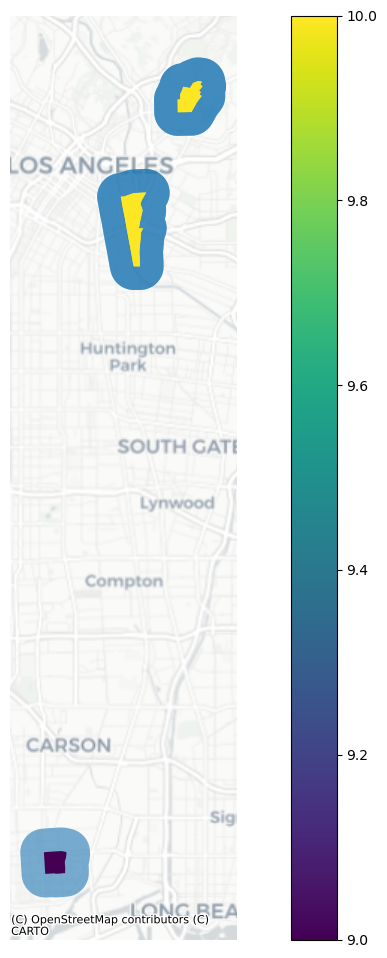

In [12]:
ax = index_buff.plot(figsize=(14,12),alpha=0.6)
ax.set_axis_off()
merged_index.plot(ax=ax,column='priority_index',legend=True,figsize=(14,12), missing_kwds={'color':'lightgrey'})
ctx.add_basemap(ax,crs=6423,
               source=ctx.providers.CartoDB.Positron)

In [13]:
index_buff

627    POLYGON ((1978813.251 561092.945, 1978853.055 ...
626    POLYGON ((1978813.251 561092.945, 1978853.055 ...
632    POLYGON ((1980278.199 564192.804, 1980281.395 ...
633    POLYGON ((1980278.199 564192.804, 1980281.395 ...
474    POLYGON ((1974615.624 532264.824, 1974614.152 ...
dtype: geometry

In [14]:
grocery = gpd.read_file('cleanedgrocery.csv')

In [15]:
grocery = gpd.GeoDataFrame(grocery, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(grocery.Longitude, grocery.Latitude))

grocery = grocery.to_crs('epsg:6423')

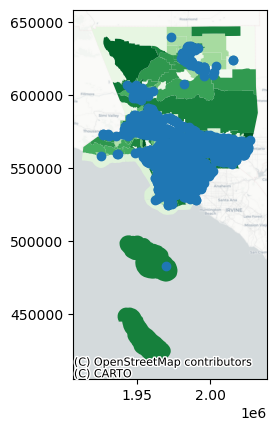

In [16]:
ax = grocery.plot(zorder=5)
latracts.plot(ax=ax,zorder=2,cmap='Greens')
ctx.add_basemap(ax,crs=6423,
               source=ctx.providers.CartoDB.Positron)

In [17]:
grocery_clip = gpd.clip(grocery,index_buff)
grocery_clip = grocery_clip.reset_index()

In [18]:
# making grocery store buffers
grocery_buff = grocery_clip.buffer(0.02)

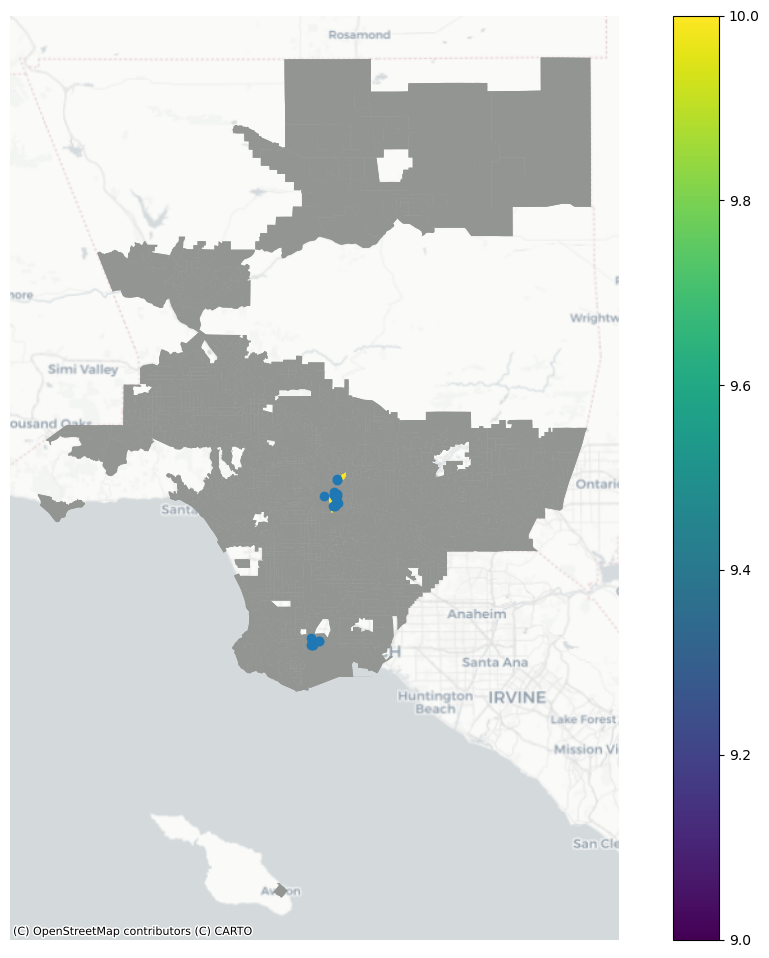

In [19]:
ax = grocery_buff.plot(figsize=(14,12),alpha = 0.5, zorder=6)
ax.set_axis_off()
tracts_census.plot(ax=ax,figsize=(14,12),color='#929591',missing_kwds={'color':'lightgrey'},zorder=2)
merged_index.plot(ax=ax,column='priority_index',legend=True,figsize=(14,12), missing_kwds={'color':'lightgrey'},zorder=8)
grocery_clip.plot(ax=ax,zorder=10)
ctx.add_basemap(ax,crs=6423,
               source=ctx.providers.CartoDB.Positron)

### Save geometry for isochrones

In [20]:
grocery_clip = grocery_clip.to_crs('epsg:4326')

In [21]:
# Extract x & y coordinates of projection for calculation within loop.
grocery_clip['Longitude'], grocery_clip['Latitude']=[grocery_clip.geometry.x,grocery_clip.geometry.y]

# Create a geodataframe to store isochrones.
isochrones_all = gpd.GeoDataFrame({'time': [99], 'geometry': [Point(1, 2)]}, crs="EPSG:4326")

# Now, loop through each grocery store to create the isochrones around the grocery store and then append these isochrones to the list.
for index, row in grocery_clip.iterrows():
    # Download the street network surrounding the grocery store.
    G = ox.graph_from_point([grocery_clip.loc[index,'Latitude'],grocery_clip.loc[index,'Longitude']], network_type='walk', dist = 2000)

    # Project this street network data so that measurements are in meters.
    G = ox.project_graph(G, to_crs='epsg:4326')

    # Convert nodes and edges to geodataframes
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

    # Use osmnx's distance.nearest_nodes command to get the id for the nearest node to the grocery store. 
    center_node = ox.distance.nearest_nodes(G,Y=grocery_clip.loc[index,'Latitude'],X=grocery_clip.loc[index,'Longitude'])

    # Create a new column, calculate the time it takes to travel that edge
    gdf_edges['walk_time'] = gdf_edges['length']/80.4672

    # loop through each trip time.
    for time in [15,10,5]:

        # For each trip time, create an egograph of nodes that fall within that time
        subgraph = nx.ego_graph(G, center_node, radius=time)

        # For each of those nodes, update the gdf_nodes dataframe and assign it with its associated time
        for node in subgraph.nodes():
                gdf_nodes.loc[node,'time'] = time

    # Create polygon containing all nodes within each time (first dissolve then create a convex hull).
    isochrones = gdf_nodes.dissolve(by = "time").convex_hull.reset_index(name='geometry')
    
    # Append these results to our growing list of isochrones.
    isochrones_all = pd.concat([isochrones_all,isochrones])

In [22]:
walkbuffers_index=isochrones_all.iloc[1:]

# Dissolve separate walksheds to create single geometry with all areas within each time.
walksheds_index=walkbuffers_index.dissolve(by = "time").reset_index().sort_values(by='time',ascending=False)

In [23]:
#saving walkshed for the top 10 census tracts of the food insecurity index
walksheds_index.to_file('grocery_walksheds_index.geojson')

In [24]:
walksheds_index.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 3 entries, 2 to 0
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   time      3 non-null      float64 
 1   geometry  3 non-null      geometry
dtypes: float64(1), geometry(1)
memory usage: 72.0 bytes


In [25]:
walksheds_index

,time,geometry
2,15.0,"MULTIPOLYGON (((-118.27252 33.77506, -118.2721..."
1,10.0,"MULTIPOLYGON (((-118.26816 33.78247, -118.2684..."
0,5.0,"MULTIPOLYGON (((-118.26563 33.78024, -118.2649..."


In [26]:
walksheds_index = walksheds_index.to_crs('epsg:6423')

In [27]:
countyboundary = gpd.read_file('LA_County_Boundary.geojson')
countyboundary.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [28]:
countyboundary = countyboundary.to_crs('epsg:6423')
countyboundary

,OBJECTID,TYPE,NAME,ShapeSTArea,ShapeSTLength,geometry
0,974,land,Los Angeles County,1.138632e+11,2.918802e+06,"MULTIPOLYGON (((1960062.537 422415.485, 196005..."


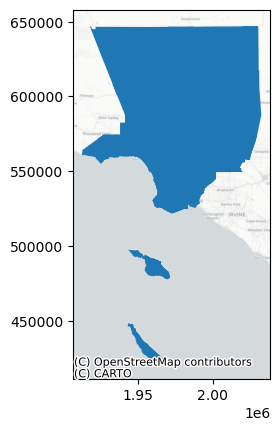

In [29]:
ax = countyboundary.plot()
tracts_census.plot(ax=ax)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

In [30]:
tracts_census = gpd.clip(tracts_census, countyboundary)

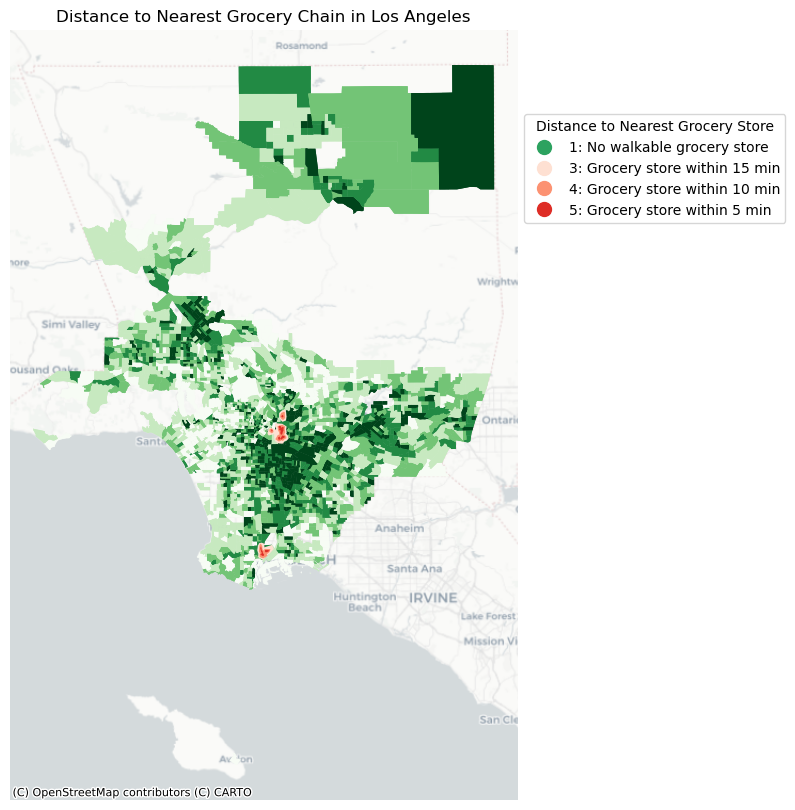

In [31]:
# Walksheds can expand into other municipalities, so we will clip the walkshed to the LA boundary.
walksheds_index_map=gpd.clip(walksheds_index, countyboundary).sort_values(by=['time'],ascending=False)

# I am going to have to create a manual legend since I have multiple layers, so I will first create a color dictionary.
color_dict = {'1: No walkable grocery store': '#2ca25f',
              '3: Grocery store within 15 min': '#fee0d2',
              '4: Grocery store within 10 min': '#fc9272',
              '5: Grocery store within 5 min': '#de2d26'}

# Now I create a "colors" column in each separate dataframe that denotes the color I want things to show up as.
walksheds_index_map.loc[walksheds_index_map['time']==5, 'colors'] = '#de2d26'
walksheds_index_map.loc[walksheds_index_map['time']==10, 'colors'] = '#fc9272'
walksheds_index_map.loc[walksheds_index_map['time']==15, 'colors'] = '#fee0d2'
tracts_census["colors"] = '#2ca25f'

# Now I create my actual map with the three geodataframes added in the appropriate order (zorder).
fig,ax = plt.subplots(figsize=(10,10))
#chain_with_neighborhood.plot(ax=ax, zorder=3,color='orange')
walksheds_index_map.plot(ax=ax, zorder=2, color=walksheds_index_map['colors'])
tracts_census.plot(ax=ax, zorder=1, column='priority_index',cmap='Greens',scheme='natural_breaks')

# Add manual legend.
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
ax.legend(custom_points, color_dict.keys(), loc='upper left', bbox_to_anchor=(1,.9), title="Distance to Nearest Grocery Store")

#Format plot axis, title, and basemap.
ax.axis('off')
ax.set_title('Distance to Nearest Grocery Chain in Los Angeles')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

/opt/conda/lib/python3.11/site-packages/mapclassify/classifiers.py:686: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  self._classify()


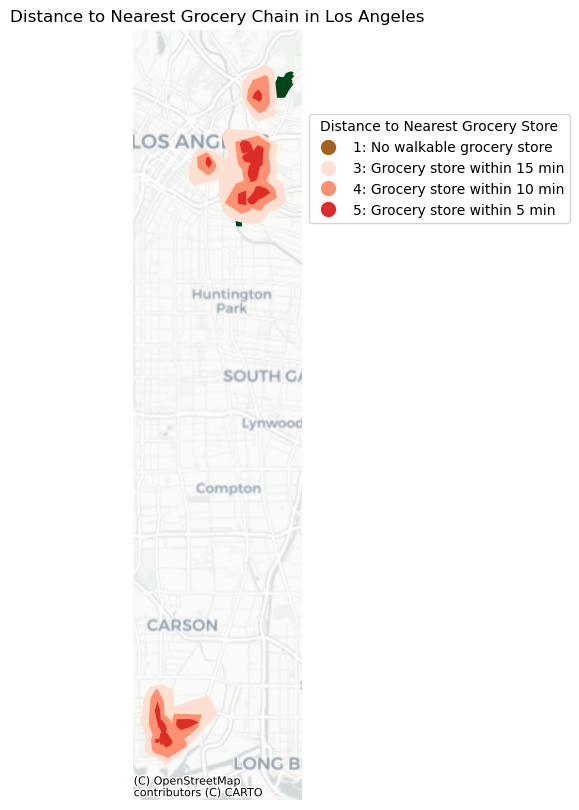

In [32]:
# Walksheds can expand into other municipalities, so we will clip the walkshed to the LA boundary.
walksheds_index_map=gpd.clip(walksheds_index, countyboundary).sort_values(by=['time'],ascending=False)

# I am going to have to create a manual legend since I have multiple layers, so I will first create a color dictionary.
color_dict = {'1: No walkable grocery store': '#a6611a',
              '3: Grocery store within 15 min': '#fee0d2',
              '4: Grocery store within 10 min': '#fc9272',
              '5: Grocery store within 5 min': '#de2d26'}

# Now I create a "colors" column in each separate dataframe that denotes the color I want things to show up as.
walksheds_index_map.loc[walksheds_index_map['time']==5, 'colors'] = '#de2d26'
walksheds_index_map.loc[walksheds_index_map['time']==10, 'colors'] = '#fc9272'
walksheds_index_map.loc[walksheds_index_map['time']==15, 'colors'] = '#fee0d2'
tracts_census["colors"] = '#a6611a'

# Now I create my actual map with the three geodataframes added in the appropriate order (zorder).
fig,ax = plt.subplots(figsize=(10,10))
#chain_with_neighborhood.plot(ax=ax, zorder=3,color='orange')
walksheds_index_map.plot(ax=ax, zorder=2, color=walksheds_index_map['colors'])
merged_index.plot(ax=ax, zorder=1,column='priority_index',cmap='Greens',scheme='natural_breaks')

# Add manual legend.
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
ax.legend(custom_points, color_dict.keys(), loc='upper left', bbox_to_anchor=(1,.9), title="Distance to Nearest Grocery Store")

#Format plot axis, title, and basemap.
ax.axis('off')
ax.set_title('Distance to Nearest Grocery Chain in Los Angeles')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

/opt/conda/lib/python3.11/site-packages/mapclassify/classifiers.py:686: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  self._classify()


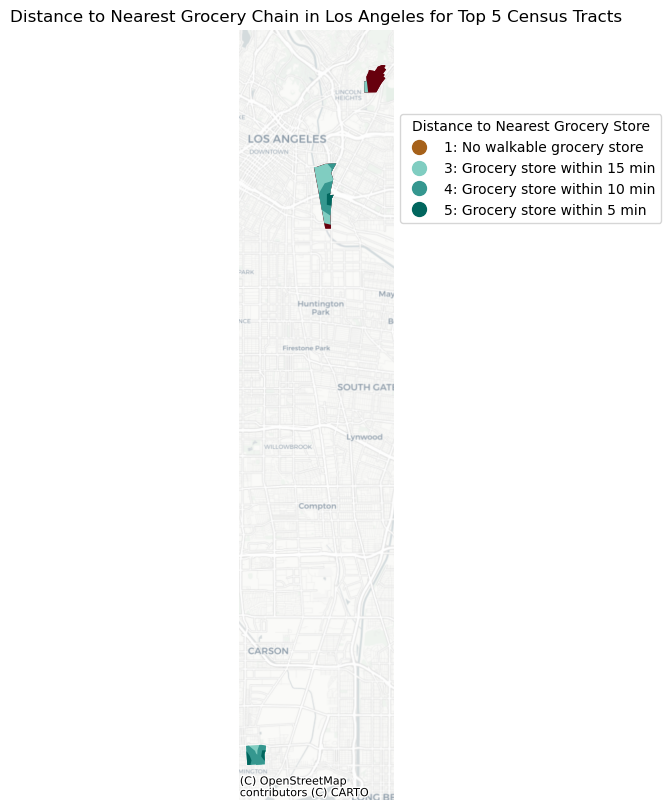

In [33]:
# Walksheds can expand into other municipalities, so we will clip the walkshed to the LA boundary.
walksheds_index_map=gpd.clip(walksheds_index, merged_index).sort_values(by=['time'],ascending=False)

# I am going to have to create a manual legend since I have multiple layers, so I will first create a color dictionary.
color_dict = {'1: No walkable grocery store': '#a6611a',
              '3: Grocery store within 15 min': '#80cdc1',
              '4: Grocery store within 10 min': '#35978f',
              '5: Grocery store within 5 min': '#01665e'}

# Now I create a "colors" column in each separate dataframe that denotes the color I want things to show up as.
walksheds_index_map.loc[walksheds_index_map['time']==5, 'colors'] = '#01665e'
walksheds_index_map.loc[walksheds_index_map['time']==10, 'colors'] = '#35978f'
walksheds_index_map.loc[walksheds_index_map['time']==15, 'colors'] = '#80cdc1'
tracts_census["colors"] = '#a6611a'

# Now I create my actual map with the three geodataframes added in the appropriate order (zorder).
fig,ax = plt.subplots(figsize=(10,10))
#chain_with_neighborhood.plot(ax=ax, zorder=3,color='orange')
walksheds_index_map.plot(ax=ax, zorder=2, color=walksheds_index_map['colors'])
merged_index.plot(ax=ax, zorder=1, column='priority_index', cmap='Reds', scheme='natural_breaks')

# Add manual legend.
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
ax.legend(custom_points, color_dict.keys(), loc='upper left', bbox_to_anchor=(1,.9), title="Distance to Nearest Grocery Store")

#Format plot axis, title, and basemap.
ax.axis('off')
ax.set_title('Distance to Nearest Grocery Chain in Los Angeles for Top 5 Census Tracts')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

### Plotting Entire LA City's Grocery Stores

In [34]:
resources = gpd.read_file('Food_Assistance.geojson',crs='epsg:4326')

In [35]:
resources_clip = gpd.clip(grocery,index_buff)
resources_clip = resources_clip.reset_index()

In [36]:
resources_clip.shape
resources_clip = resources_clip.to_crs('epsg:4326')

In [37]:
# Extract x & y coordinates of projection for calculation within loop.
resources_clip['Longitude'], resources_clip['Latitude']=[resources_clip.geometry.x,resources_clip.geometry.y]

# Create a geodataframe to store isochrones.
isochrones_noclip_all = gpd.GeoDataFrame({'time': [99], 'geometry': [Point(1, 2)]}, crs="epsg:4326").copy()

# Now, loop through each grocery store to create the isochrones around the grocery store and then append these isochrones to the list.
for index, row in resources_clip.iterrows():
    # Download the street network surrounding the grocery store.
    G = ox.graph_from_point([resources_clip.loc[index,'Latitude'],resources_clip.loc[index,'Longitude']], network_type='walk', dist = 2000)

    # Project this street network data so that measurements are in meters.
    G = ox.project_graph(G, to_crs='epsg:4326')
    
    # Convert nodes and edges to geodataframes
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
    
    # Use osmnx's distance.nearest_nodes command to get the id for the nearest node to the grocery store. 
    center_node = ox.distance.nearest_nodes(G,Y=resources_clip.loc[0,'Latitude'],X=resources_clip.loc[0,'Longitude'])
    
    # Create a new column, calculate the time it takes to travel that edge
    gdf_edges['walk_time'] = gdf_edges['length']/80.4672
    
    # loop through each trip time.
    for time in [15,10,5]:
    
    # For each trip time, create an egograph of nodes that fall within that time
        subgraph = nx.ego_graph(G, center_node, radius=time)
    
    # For each of those nodes, update the gdf_nodes dataframe and assign it with its associated time
        for node in subgraph.nodes():
                gdf_nodes.loc[node,'time'] = time
    
    # Create polygon containing all nodes within each time (first dissolve then create a convex hull).
        isochrones_noclip = gdf_nodes.dissolve(by = "time")
        isochrones_noclip = isochrones_noclip.convex_hull.reset_index(name='geometry')

    # Append these results to our growing list of isochrones.
    isochrones_noclip_all = pd.concat([isochrones_noclip_all,isochrones_noclip])

In [38]:
walkbuffers_resources=isochrones_noclip_all.iloc[1:]

# Dissolve separate walksheds to create single geometry with all areas within each time.
walksheds_resources=walkbuffers_resources.dissolve(by = "time").reset_index().sort_values(by='time',ascending=False)

In [39]:
#saving walkshed for the top 10 census tracts of the food insecurity index
walksheds_resources.to_file('resources_walksheds.geojson')

In [40]:
walksheds_resources

,time,geometry
2,15.0,"MULTIPOLYGON (((-118.27203 33.78448, -118.2715..."
1,10.0,"MULTIPOLYGON (((-118.26747 33.78474, -118.2662..."
0,5.0,"MULTIPOLYGON (((-118.26563 33.78024, -118.2649..."


In [41]:
countyboundary = countyboundary.to_crs('epsg:6423')
countyboundary

,OBJECTID,TYPE,NAME,ShapeSTArea,ShapeSTLength,geometry
0,974,land,Los Angeles County,1.138632e+11,2.918802e+06,"MULTIPOLYGON (((1960062.537 422415.485, 196005..."


In [42]:
walksheds_resources = walksheds_resources.to_crs('epsg:6423')
walksheds_resources

,time,geometry
2,15.0,"MULTIPOLYGON (((1974803.307 531591.193, 197485..."
1,10.0,"MULTIPOLYGON (((1975225.947 531618.444, 197533..."
0,5.0,"MULTIPOLYGON (((1975394.963 531119.484, 197545..."


In [43]:
walksheds_resources_map=gpd.clip(walksheds_resources, countyboundary).sort_values(by=['time'],ascending=False)
walksheds_resources_map

,time,geometry
2,15.0,"MULTIPOLYGON (((1974850.763 531826.427, 197493..."
1,10.0,"MULTIPOLYGON (((1975335.785 531540.261, 197544..."
0,5.0,"MULTIPOLYGON (((1975454.262 531115.711, 197550..."


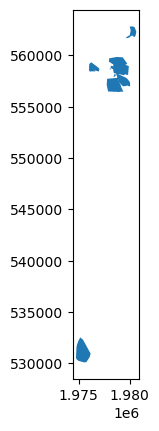

In [44]:
ax=walksheds_resources_map.plot()

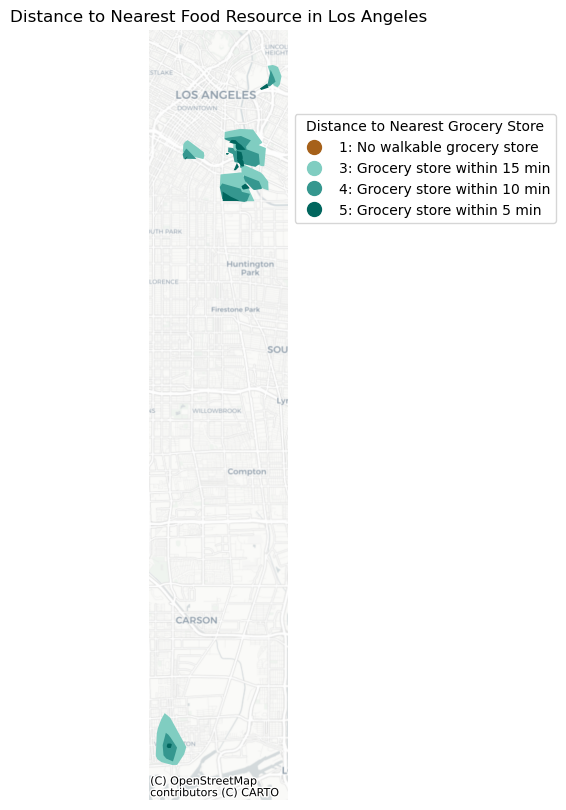

In [45]:
# Walksheds can expand into other municipalities, so we will clip the walkshed to the LA boundary.
walksheds_resources_map=gpd.clip(walksheds_resources, countyboundary).sort_values(by=['time'],ascending=False)

# I am going to have to create a manual legend since I have multiple layers, so I will first create a color dictionary.
color_dict = {'1: No walkable grocery store': '#a6611a',
              '3: Grocery store within 15 min': '#80cdc1',
              '4: Grocery store within 10 min': '#35978f',
              '5: Grocery store within 5 min': '#01665e'}

# Now I create a "colors" column in each separate dataframe that denotes the color I want things to show up as.
walksheds_resources_map.loc[walksheds_resources_map['time']==5, 'colors'] = '#01665e'
walksheds_resources_map.loc[walksheds_resources_map['time']==10, 'colors'] = '#35978f'
walksheds_resources_map.loc[walksheds_resources_map['time']==15, 'colors'] = '#80cdc1'
tracts_census["colors"] = '#a6611a'

# Now I create my actual map with the three geodataframes added in the appropriate order (zorder).
fig,ax = plt.subplots(figsize=(10,10))
#chain_with_neighborhood.plot(ax=ax, zorder=3,color='orange')
walksheds_resources_map.plot(ax=ax, zorder=2, color=walksheds_resources_map['colors'])
#merged_index.plot(ax=ax, zorder=1, color=tracts_census['colors'])

# Add manual legend.
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
ax.legend(custom_points, color_dict.keys(), loc='upper left', bbox_to_anchor=(1,.9), title="Distance to Nearest Grocery Store")

#Format plot axis, title, and basemap.
ax.axis('off')
ax.set_title('Distance to Nearest Food Resource in Los Angeles')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

### Folium Map Analysis

Our code is too large to run in our notebook so we attached our code but did not run. See html download link in our Group Repo for code and output. 

In [ ]:
df = pd.read_csv("merged_MAR16.csv")

gdf = gpd.GeoDataFrame(df, geometry=df['wkt'].apply(loads))
gdf.set_crs(epsg=3857, inplace=True)

gdf = gdf.dropna()

invalid_geometries = gdf[~gdf.is_valid]
print(f"Found {len(invalid_geometries)} invalid geometries")
gdf['geometry'] = gdf.geometry.buffer(0)

gdf['snap_rate'] = gdf['snap_rate'].astype(float)
gdf['chd_pct'] = gdf['chd_pct'].astype(float)
gdf['lowaccess_pct'] = gdf['lowaccess_pct'].astype(float)
gdf['lowaccess_li_pct'] = gdf['lowaccess_li_pct'].astype(float)
gdf['snap_rate'] = gdf['snap_rate'].astype(float)
gdf['total_pop'] = gdf['total_pop'].astype(int)

gdf['centroid'] = gdf.geometry.centroid
centroids_geo = gdf['centroid'].to_crs(epsg=4326)


gdf['longitude'] = centroids_geo.x
gdf['latitude'] = centroids_geo.y

gdf = gdf[["geometry", "snap_rate", "chd_pct", "lowaccess_pct", "lowaccess_li_pct", "geoid20", "SPA_NAME", "pop_ages_65_older_pct", "latino_pct", "unemployed_pct"]]

spa_colors = {
    'West': 'red',
    'San Fernando': 'blue',
    'South': 'green',
    'San Gabriel': 'purple',
    'Antelope Valley': 'orange',
    'South Bay': 'yellow',
    'Metro': 'brown',
    'East': 'gray'
}

index_colors = {
    0: '#ffffcc', # light yellow
    1: '#ffeda0', # light orange
    2: '#fed976', # slightly darker orange
    3: '#feb24c', # orange
    4: '#fd8d3c', # dark orange
    5: '#fc4e2a', # reddish orange
    6: '#e31a1c', # red
    7: '#bd0026', # dark red
    8: '#800026', # burgundy
    9: '#400026', # dark burgundy
    10: '#000000' # black
}

spa_colors

gdf = gpd.GeoDataFrame(gdf, geometry=gdf["geometry"])
gdf.set_crs(epsg=3857, inplace=True)

classifier = mapclassify.NaturalBreaks.make(k=5)

# Age score
gdf['age_pct_score'] = gdf[['pop_ages_65_older_pct']].apply(classifier)
gdf[['pop_ages_65_older_pct', 'age_pct_score']].head()

# Hispanic score
gdf['hisp_pct_score'] = gdf[['latino_pct']].apply(classifier)
gdf[['latino_pct', 'hisp_pct_score']].head()

# Unemployment score
gdf['emp_pct_score'] = gdf[['unemployed_pct']].apply(classifier)
gdf[['unemployed_pct', 'emp_pct_score']].head()

# Food Index: Age + Hispanic + Unemployment scores 
gdf['priority_index'] = gdf['age_pct_score'] + gdf['hisp_pct_score'] + gdf['emp_pct_score']

gdf['priority_index'].unique()

chd_pct_min = gdf['chd_pct'].min()
chd_pct_max = gdf['chd_pct'].max()

snap_rate_min = gdf['snap_rate'].min()
snap_rate_max = gdf['snap_rate'].max()

lowaccess_li_pct_min = 0
lowaccess_li_pct_max = 0.05

lowaccess_pct_min = 0
lowaccess_pct_max = 0.05

priority_min = 0
priority_max = 10

def style_function_snap_rate(feature):
    return {
        'fillColor': colormap_snap_rate(feature['properties']['snap_rate']),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7
    }

def style_function_chd_pct(feature):
    return {
        'fillColor': colormap_chd_pct(feature['properties']['chd_pct']),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7
    }

def style_function_lowaccess_li_pct(feature):
    return {
        'fillColor': colormap_chd_pct(feature['properties']['lowaccess_li_pct']),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7
    }

def style_function_lowaccess_pct(feature):
    return {
        'fillColor': colormap_chd_pct(feature['properties']['lowaccess_pct']),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7
    }

def style_function_spa(feature):
    return {
        'color': spa_colors.get(feature['properties']['SPA_NAME'], 'white'),  # Boundary color
        'weight': 1,
        'fillOpacity': 0,
        "dashArray": "5, 5"
    }

def style_function_priority(feature):
    return {
        'fillColor': index_colors.get(feature['properties']['priority_index'], 'white'),
        'weight': 0,
        'fillOpacity': 0.7
    }

colormap_snap_rate = cm.linear.YlOrRd_09.scale(snap_rate_min, snap_rate_max).to_step(n=5)
colormap_chd_pct = cm.linear.Blues_09.scale(chd_pct_min, chd_pct_max).to_step(n=5)
colormap_lowaccess_li_pct =cm.linear.YlOrRd_09.scale(lowaccess_li_pct_min, lowaccess_li_pct_max).to_step(n=5)
colormap_lowaccess_pct = cm.linear.Blues_09.scale(lowaccess_pct_min, lowaccess_pct_max).to_step(n=5)

colormap_snap_rate.caption = "SNAP Rate"
colormap_chd_pct.caption = "CHD Percentage"
colormap_lowaccess_li_pct.caption = "Low Access Low Income Percentage"
colormap_lowaccess_pct.caption = "Low Access Percentage"

bounds = gdf.total_bounds

center_lat = (bounds[1] + bounds[3]) / 2
center_lon = (bounds[0] + bounds[2]) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

geojson_data = gdf.to_json()

#snap_rate_layer = folium.GeoJson(
#    geojson_data,
#    style_function=style_function_snap_rate,
#    name='SNAP Rate',
#    popup=folium.GeoJsonPopup(fields=['snap_rate', 'chd_pct', 'lowaccess_li_pct', 'lowaccess_pct'], 
#                              aliases=['SNAP Rate:', 'CHD %:', 'Low Income Low Access %', 'Low Access %'], 
#                              labels=True)
#).add_to(m)

chd_pct_layer = folium.GeoJson(
    geojson_data,
    style_function=style_function_chd_pct,
    name='CHD Percentage',
    popup=folium.GeoJsonPopup(fields=['snap_rate', 'chd_pct', 'lowaccess_li_pct', 'lowaccess_pct'], 
                              aliases=['SNAP Rate:', 'CHD %:', 'Low Income Low Access %', 'Low Access %'], 
                              labels=True)
).add_to(m)

#lowaccess_li_pct_layer = folium.GeoJson(
#    geojson_data,
#    style_function=style_function_lowaccess_li_pct,
#    name='Low Income Low Access Percentage',
#    popup=folium.GeoJsonPopup(fields=['snap_rate', 'chd_pct', 'lowaccess_li_pct', 'lowaccess_pct'], 
#                              aliases=['SNAP Rate:', 'CHD %:', 'Low Income Low Access %', 'Low Access %'], 
#                              labels=True)
#).add_to(m)

#lowaccess_pct_layer = folium.GeoJson(
#    geojson_data,
#    style_function=style_function_lowaccess_pct,
#    name='Low Access Percentage',
#    popup=folium.GeoJsonPopup(fields=['snap_rate', 'chd_pct', 'lowaccess_li_pct', 'lowaccess_pct'], 
#                              aliases=['SNAP Rate:', 'CHD %:', 'Low Income Low Access %', 'Low Access %'], 
#                              labels=True)
#).add_to(m)

spa_layer = folium.GeoJson(
    geojson_data,
    style_function=style_function_spa,
    name='SPA Overlay',
    popup=folium.GeoJsonPopup(fields=['SPA_NAME'], aliases=['Service Planning Area:'], labels=True)
).add_to(m)

index_layer = folium.GeoJson(
    geojson_data,
    style_function=style_function_priority,
    name='FI Index Overlay',
    popup=folium.GeoJsonPopup(fields=['priority_index'], aliases=['Priority Index:'], labels=True)
).add_to(m)

#colormap_snap_rate.add_to(m)
colormap_chd_pct.add_to(m)
#colormap_lowaccess_li_pct.add_to(m)
#colormap_lowaccess_pct.add_to(m)

folium.LayerControl().add_to(m)

m